Dataset Information:
Total rows: 3340
Total columns: 7

Column Types:
Unnamed: 0            int64
Location             object
Accident_Type        object
Accident_Count        int64
Year_Column           int64
Date                 object
Accident_Category    object
dtype: object


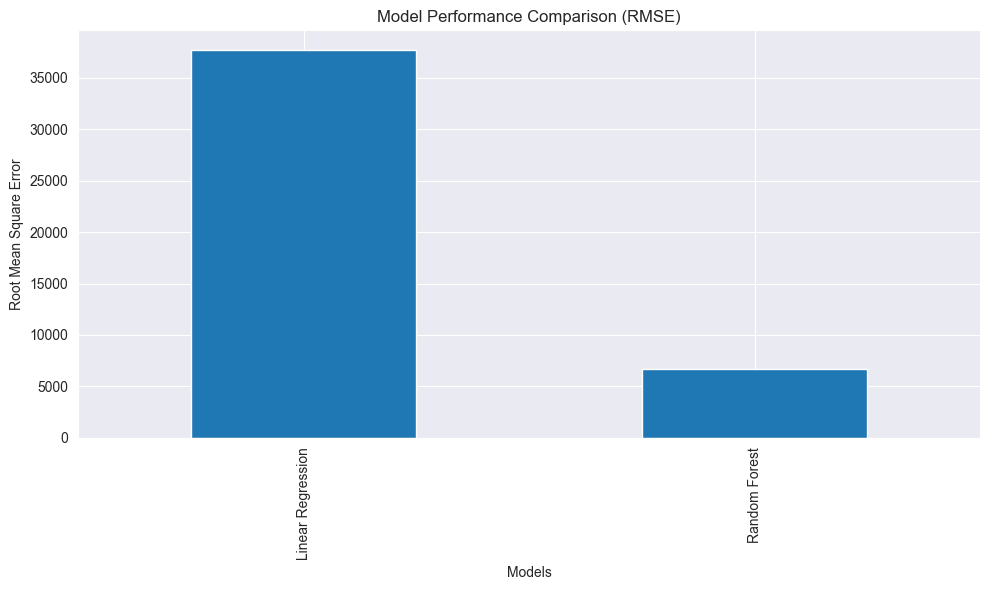


Detailed Model Performance:
                           MAE          RMSE        R²
Linear Regression  34467.81310  37733.580814  0.678436
Random Forest       3228.85497   6724.371788  0.989788


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import XGBoost Regressor differently
from xgboost import XGBRegressor

def preprocess_data(df, target_column='Accident_Count'):
    """
    Prepare data for machine learning by:
    1. Separating features and target
    2. Identifying numeric and categorical columns
    3. Creating preprocessing pipeline
    """
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identify column types
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            # Numeric columns: impute missing values, then scale
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),

            # Categorical columns: impute, then one-hot encode
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])

    return X, y, preprocessor

def train_and_evaluate_models(X, y, preprocessor):
    """
    Train multiple regression models and evaluate their performance.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models with preprocessing pipeline
    models = {
        "Linear Regression": Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        "Random Forest": Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
#        ]),
#        "XGBoost": Pipeline([
#            ('preprocessor', preprocessor),
#            ('regressor', XGBRegressor(n_estimators=100, random_state=42,
#                                        # Add these parameters to avoid potential issues
#                                        learning_rate=0.1,
#                                        max_depth=3))
        ])
    }

    # Train and evaluate models
    results = {}
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        results[name] = {
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R²": r2_score(y_test, y_pred)
        }

    return results

def visualize_results(results):
    """
    Create a bar plot comparing model performance.
    """
    # Convert results to DataFrame
    df_results = pd.DataFrame.from_dict(results, orient='index')

    # Create bar plot for RMSE
    plt.figure(figsize=(10, 6))
    df_results['RMSE'].plot(kind='bar')
    plt.title('Model Performance Comparison (RMSE)')
    plt.ylabel('Root Mean Square Error')
    plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nDetailed Model Performance:")
    print(df_results)

def main():
    # Direct CSV loading
    df = pd.read_csv("cleaned_traffic_accidents_with_separate_year.csv")

    # Print basic information about the dataset
    print("Dataset Information:")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}")
    print("\nColumn Types:")
    print(df.dtypes)

    # Specify your target column
    target_column = "Accident_Count"

    # Preprocess Data
    X, y, preprocessor = preprocess_data(df, target_column)

    # Train and Evaluate Models
    results = train_and_evaluate_models(X, y, preprocessor)

    # Visualize Results
    visualize_results(results)

# Run the main function
if __name__ == "__main__":
    main()

Random Forest performs better

Model Performance Metrics:

Column: Accident_Count
MAE: 53623.8902
MSE: 4630408807.6274
R2: -0.0607


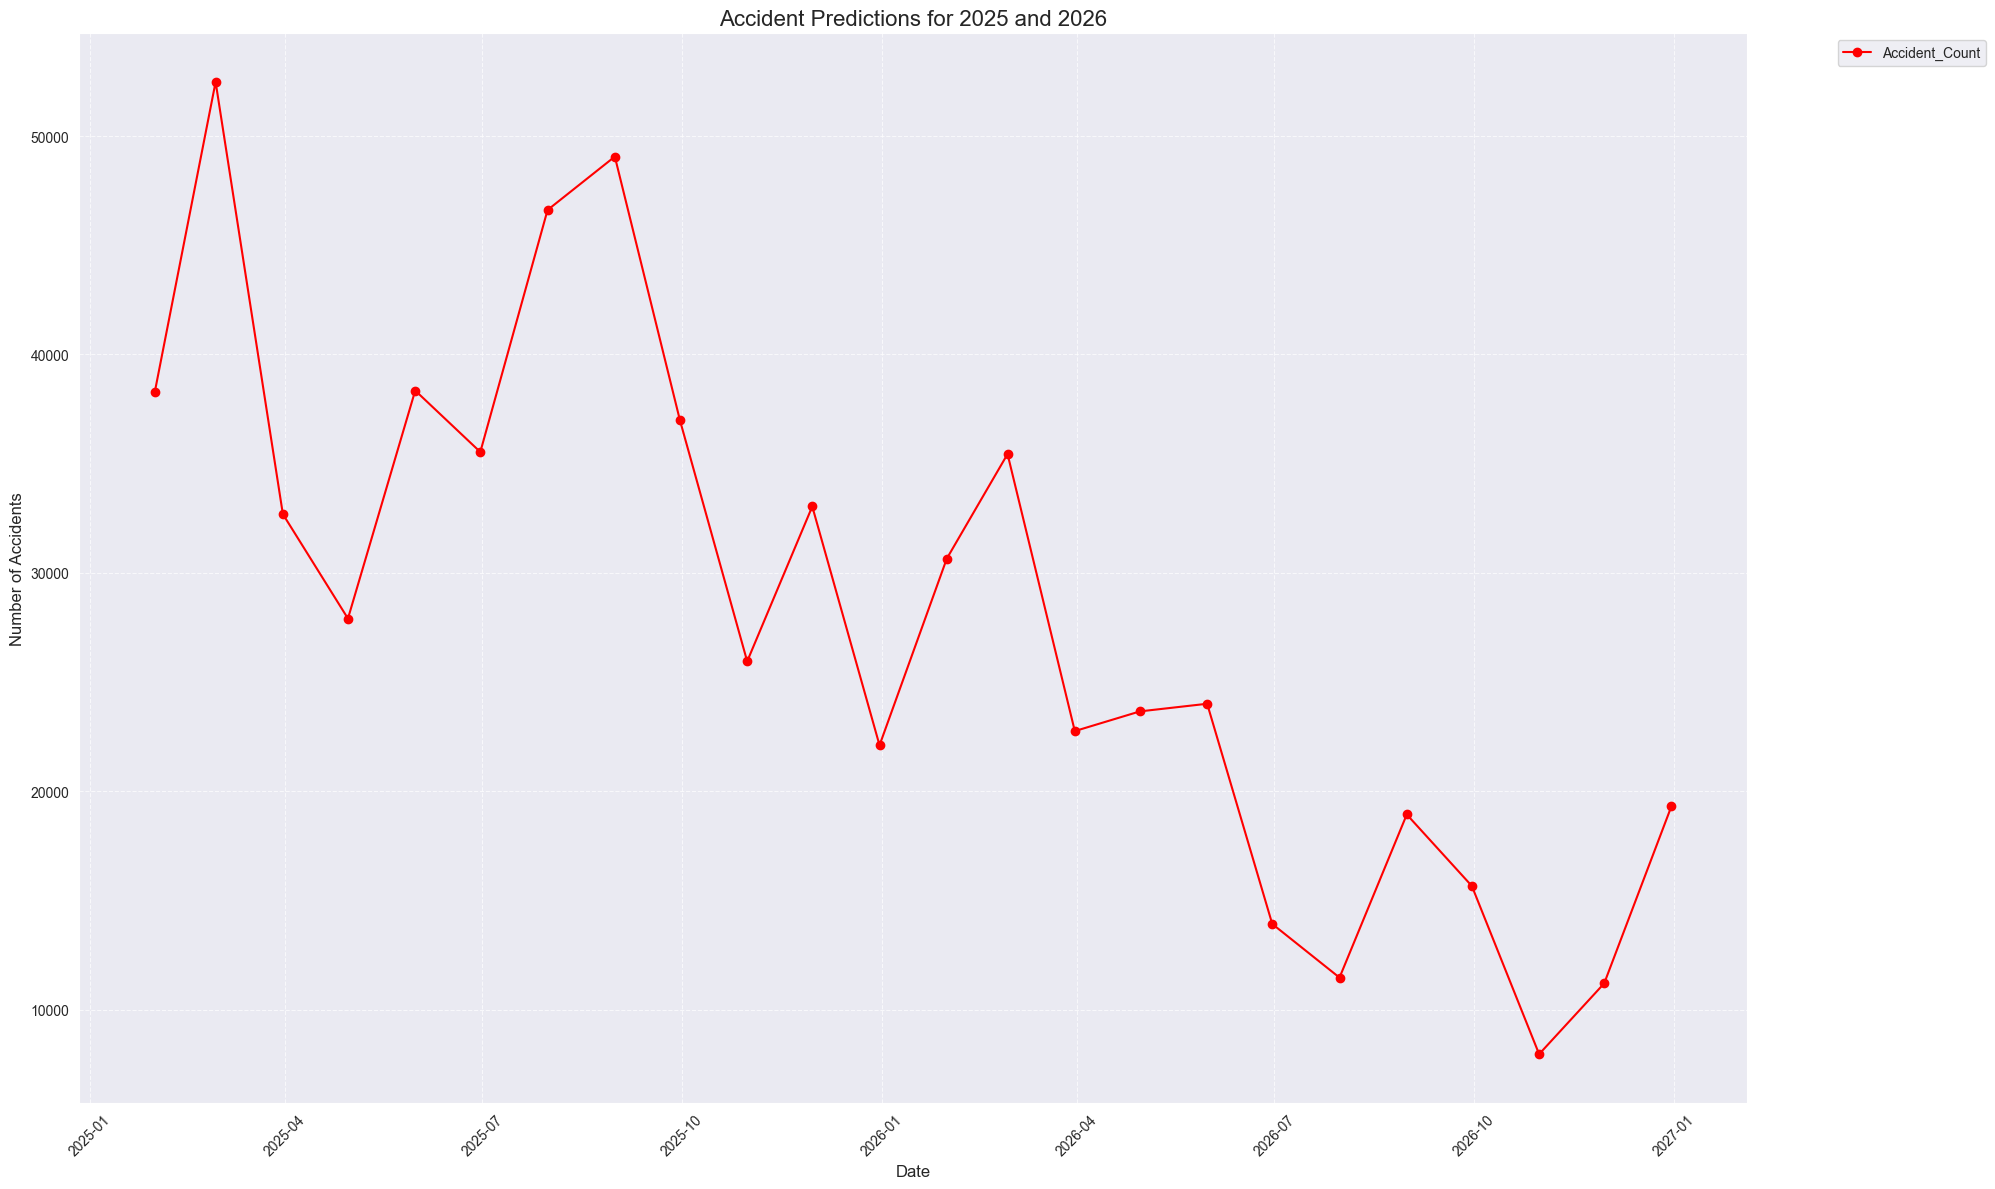


Predictions for Future Months:

Accident_Count:
2024-11: 26564.27
2024-12: 28660.09
2025-01: 38295.87
2025-02: 52475.81
2025-03: 32685.83
2025-04: 27903.92
2025-05: 38344.34
2025-06: 35530.76
2025-07: 46613.08
2025-08: 49057.92
2025-09: 36986.12
2025-10: 25944.61
2025-11: 33036.28
2025-12: 22101.51
2026-01: 30648.84
2026-02: 35436.32
2026-03: 22750.81
2026-04: 23652.88
2026-05: 24002.13
2026-06: 13919.09
2026-07: 11462.84
2026-08: 18931.42
2026-09: 15657.13
2026-10: 7957.57
2026-11: 11199.76
2026-12: 19313.87
2027-01: 14171.92
2027-02: 24423.23
2027-03: 25393.66
2027-04: 10894.92
2027-05: 14884.38
2027-06: 18227.18
2027-07: 9674.27
2027-08: 24149.66
2027-09: 19835.29
2027-10: 17733.27


In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def prepare_data(df):
    """Prepares time series sequences for training, excluding 'Unnamed' and 'Year' columns."""
    df['Date'] = pd.to_datetime(df['Date'])
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if 'Unnamed' not in col and 'Year' not in col]

    features = []
    for column in numeric_columns:
        X, y = [], []
        for i in range(len(df) - 48):
            X.append(df[column].values[i:i+48])
            y.append(df[column].values[i+48])

        if X:  # Avoid appending empty arrays
            features.append((column, np.array(X), np.array(y)))

    return features, numeric_columns

def train_random_forest_models(features):
    """Trains a Random Forest model for each feature column."""
    models = {}

    for column, X, y in features:
        if len(X) == 0:  # Skip if not enough data
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train_scaled, y_train)

        y_pred = rf.predict(X_test_scaled)

        models[column] = {
            'model': rf,
            'scaler': scaler,
            'metrics': {
                'MAE': mean_absolute_error(y_test, y_pred),
                'MSE': mean_squared_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)
            }
        }

    return models

def predict_future_months(df, models, num_months=36):
    """Generates future accident predictions for each feature column."""
    predictions = {}

    for column, model_info in models.items():
        last_sequence = df[column].values[-48:].reshape(1, -1)  # Ensure correct shape

        column_predictions = []
        for _ in range(num_months):
            scaled_features = model_info['scaler'].transform(last_sequence)
            prediction = model_info['model'].predict(scaled_features)[0]
            column_predictions.append(prediction)

            last_sequence = np.roll(last_sequence, -1)  # Shift window
            last_sequence[0, -1] = prediction  # Update last value

        predictions[column] = column_predictions

    return predictions

def plot_predictions(predictions, future_dates):
    """Plots predictions for 2025 and 2026 only."""
    plt.figure(figsize=(20, 12))

    # Filter dates for 2025 and 2026
    mask = (future_dates.year >= 2025) & (future_dates.year <= 2026)
    filtered_dates = future_dates[mask]

    for column, pred_values in predictions.items():
        filtered_values = np.array(pred_values)[mask]  # Filter corresponding predictions
        plt.plot(filtered_dates, filtered_values, label=column, marker='o', color="red")

    plt.title('Accident Predictions for 2025 and 2026', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def main(file_path):
    """Loads data, trains models, makes predictions, and plots results."""
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.loc[:, ~df.columns.str.contains('Unnamed')]  # Remove unnamed columns

    features, _ = prepare_data(df)
    models = train_random_forest_models(features)

    print("Model Performance Metrics:")
    for column, model_info in models.items():
        print(f"\nColumn: {column}")
        for metric, value in model_info['metrics'].items():
            print(f"{metric}: {value:.4f}")

    last_date = df['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=36, freq='ME')

    predictions = predict_future_months(df, models, num_months=36)
    plot_predictions(predictions, future_dates)

    print("\nPredictions for Future Months:")
    for column, pred_values in predictions.items():
        print(f"\n{column}:")
        for date, value in zip(future_dates, pred_values):
            print(f"{date.strftime('%Y-%m')}: {value:.2f}")

    return predictions

# Run the main function
predictions = main('cleaned_traffic_accidents_with_separate_year.csv')